# Elevated-Plus Maze Analysis
- Behavior is 30 fps, cell activity is 20 fps for drd73, drd77 and 10 fps for drd87, drd46

In [7]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import matplotlib.style as style
import Core
import analysis_utils as au

from scipy import stats
from plotly import tools
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

# For function testing purposes
import TestDataFrames as TDF
from timeit import default_timer as timer

plotly.offline.init_notebook_mode(connected=True);
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

### First, we import a CSV of the trace raw data for drd87

In [9]:
data = pd.read_csv('~/d87EPMraw.csv', header=None)

start = timer()
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)
end = timer()

# Name all the columns in each data frame as such: neuron1, neuron2, ..., neuron_n
z_scored_dataframe.columns = ['neuron' + str(i) for i in range(1, len(z_scored_dataframe.columns)+1)]
AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
cell_transients_dataframe.columns = ['neuron' + str(i) for i in range(1, len(cell_transients_dataframe.columns)+1)]

### We begin with a simple correlation matrix to get our bearings

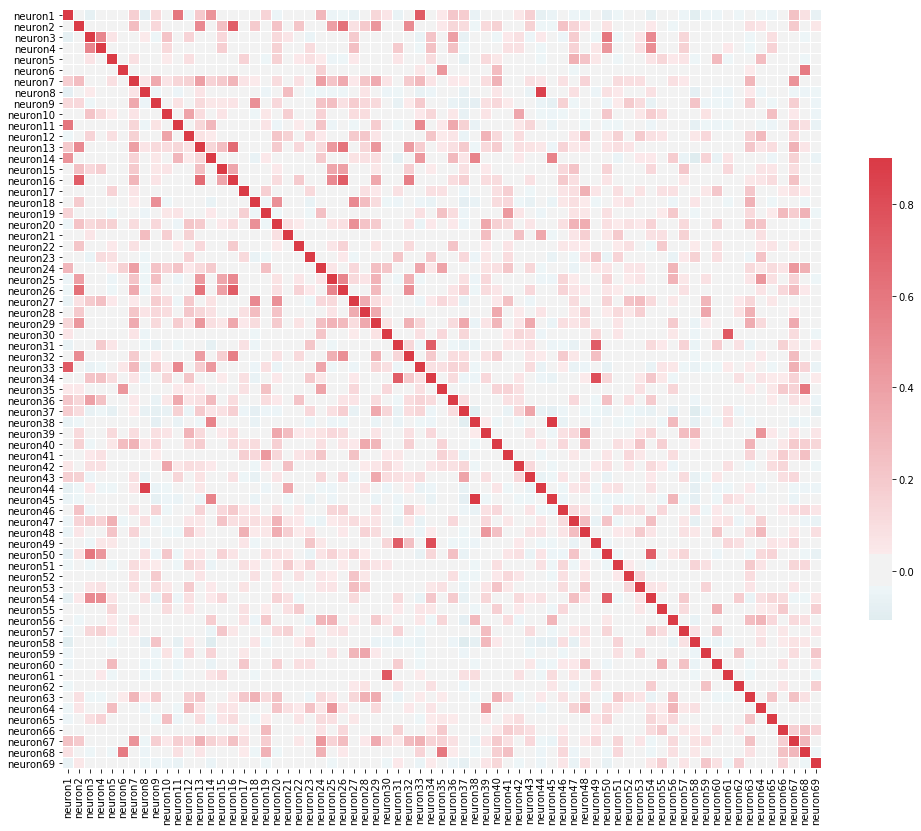

In [11]:
# Compute the correlation matrix
corr = cell_transients_dataframe.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(17, 17))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.9, center=0, square=True, linewidths=.1, cbar_kws={"shrink": .5});

### Next, we assign a correlation value of interest, and we loop through our entire cell transients dataframe to find pairs of neurons that have that correlation value, or greater
- Note that we utilize another homebrewed function in order to get back two objects:
 - fig: an object that tells plotly how and what to plot on the scatter plot
 - r_value: the correlation coefficient of the two neurons passed into the function, `neuron_scatter_plot_with_reg()`
- Finally, we print out the total amount of correlated pairs of neurons found in the cell transients dataframe for drd87

In [12]:
# Find and plot all pairs of neurons that have a specified correlation
corr_pairs_of_neurons = 0
COR_VAL = 0.3
columns = cell_transients_dataframe.columns.tolist()
for i in range(0, len(columns)):
    for j in range(i+1, len(columns)):
        fig, r_value = au.neuron_scatter_plot_with_reg(columns[i], columns[j], cell_transients_dataframe)
        if r_value >= COR_VAL and fig != False:
            corr_pairs_of_neurons += 1

print("Total amount of correlated pairs of neurons: {}".format(corr_pairs_of_neurons))

Total amount of correlated pairs of neurons: 92


### Our functions let us know that neuron 38 and neuron 45 have a correlation of 0.92   
#### We use a homebrewed function to plot two neurons located in the cell transients dataframe

In [13]:
fig, r_value = au.neuron_scatter_plot_with_reg('neuron38', 'neuron45', cell_transients_dataframe)
plotly.offline.iplot(fig)
au.neuron_line_plot('neuron38', 'neuron45', cell_transients_dataframe)

#### A better way to decide whether or not two neurons are correlated:
$$q=\frac{|\vec{n_1} \wedge \vec{n_2}|}{|\vec{n_1} \vee \vec{n_2}|}$$

In [ ]:
# corr_df = cell_transients_dataframe[(cell_transients_dataframe['neuron1'] != 0) & (cell_transients_dataframe['neuron3'] != 0)]

In [ ]:
# result_dataframe.plot.scatter(x='Trial_time', y='neuron7');

neuron7_list = list()
for i in range(0, result_dataframe['neuron7'].size):
    if result_dataframe['Open2_centerpoint'][i] != 0:
        neuron7_list.append(result_dataframe['neuron7'][i])
    else:
        neuron7_list.append(np.nan)

# neuron7_dataframe = result_dataframe[['Trial time']].copy()
# neuron7_dataframe['neuron7'] = pd.Series(neuron7_list)
# neuron7_dataframe['neuron7'][neuron7_dataframe['neuron7'] > 0]
# neuron7_dataframe['neuron7'] = pd.DataFrame(columns=[n]neuron7_list)
# sns.regplot(x=result_dataframe['Trial time'], y=neuron7_dataframe['neuron7'], color="g");

In [ ]:
FRAME_RATE = 10
run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] != 0].index.tolist()
no_run_vector = behavior_df['Running_frames'][behavior_df['Running_frames'] == 0].index.tolist()

run_sums = [activity_df[column][run_vector].sum() for column in activity_df]
no_run_sums = [activity_df[column][no_run_vector].sum() for column in activity_df]   

run_sums1 = [FRAME_RATE * run_sums[i] / len(run_vector) for i in range(0, len(run_sums))]
no_run_sums1 = [FRAME_RATE * no_run_sums[i] / len(no_run_vector) for i in range(0, len(no_run_sums))]

run_noruns_dataframe = pd.DataFrame(columns=['runs', 'norun'])
run_noruns_dataframe['runs'] = pd.Series(run_sums1)
run_noruns_dataframe['norun'] = pd.Series(no_run_sums1)
# run_noruns_dataframe.plot.bar(figsize=(17, 5), rot=0);
# data_1 = [Bar(x=run_noruns_dataframe, y=run_noruns_dataframe)]
# plotly.offline.iplot(data_1)